## README
    load in data stream 
    get 255 samples every 10s and read in
    testing purposes: number of blinks in 1 min

In [1]:
import pandas as pd

In [2]:
#pip install colabcode
#from colabcode import ColabCode
#ColabCode(port = 10000, password= "password123")

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
pip install neurokit2

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mne
# %pip install mne

SyntaxError: invalid syntax (<ipython-input-5-821ec1e7c9c1>, line 1)

In [6]:
%pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install torchtyping

Note: you may need to restart the kernel to use updated packages.


## IMPORTS

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from itertools import groupby
import pandas as pd
import math
import neurokit2 as nk
#!pip install mne

# Read data

In [3]:
path1 = 'data/data/5blinks/exg0.csv'
blink5 = pd.read_csv(path1)
path2 = 'data/data/15blink/exg0.csv'
blink10 = pd.read_csv(path2)
path3 = 'data/data/attentivU/natasha/test5/exg0.csv'
natasha = pd.read_csv(path3)
danielp = pd.read_csv('data/data/attentivU/danielp/test1/exg0.csv')
nmaniar = pd.read_csv('data/data/attentivU/nmaniar/test2/exg0.csv')
skykim = pd.read_csv('data/data/attentivU/skykim/test1/exg0.csv')
sven = pd.read_csv('data/data/attentivU/skykim/test1/exg0.csv')

#path1 = '/content/drive/MyDrive/Streamer-main/ml/t59/exg0.csv'
#path2 = '/content/drive/MyDrive/Colab Notebooks/Streamer-main/ml/15blink/exg0.csv'

In [142]:
natasha

,UTC_TIME,SAMPLE_NUMBER,CH1,CH2,CH3,LABEL,
0,2023-05-15 14:44:42.920685,145.0,-0.070518,-0.075618,-0.068949,N,NaN
1,2023-05-15 14:44:42.924685,146.0,-0.070562,-0.075613,-0.068936,N,NaN
2,2023-05-15 14:44:42.928685,147.0,-0.070543,-0.075618,-0.068940,N,NaN
3,2023-05-15 14:44:42.932685,148.0,-0.070502,-0.075629,-0.068949,N,NaN
4,2023-05-15 14:44:42.936685,149.0,-0.070517,-0.075624,-0.068952,N,NaN
...,...,...,...,...,...,...,...
2075,2023-05-15 14:44:51.607178,16.0,-0.072387,-0.077536,-0.070872,N,NaN
2076,2023-05-15 14:44:51.611178,17.0,-0.072351,-0.077544,-0.070879,N,NaN
2077,2023-05-15 14:44:51.615178,18.0,-0.072367,-0.077536,-0.070887,N,NaN
2078,2023-05-15 14:44:51.619178,19.0,-0.072407,-0.077527,-0.070883,N,NaN


In [4]:
def import_data(path, columns_name, sep=True):
    '''
    Return pandas DataFrame.
    :param path: str. Path of the dataset
    :param columns_name: list of str. Columns name
    :param sep: boolean. Set True/False when length issue with columns number
    '''
    if sep:
        df = pd.read_csv(path, sep=" ", header=0, names=columns_name)
    else :
        df = pd.read_csv(path, header=0, names=columns_name)
    return df


def plot_from_dict(events_dict, df_data, coi, x_data):
    '''
    Utility function for plot_eog that helps to plot for mode "double" and "triple"

    :param events_dict: dict. Dict of events {value, label, color of the plot}
    :param df_data: pandas Dataframe.
    :param coi: list of str or str. list or str of channel(s) of interest
    :param x_data: np.array. X-axis data.
    '''
    for key in events_dict:
        y = np.where(df_data["label"] == events_dict[key]["value"], df_data[coi], None)
        plt.plot(x_data, y, color=events_dict[key]["color"], label=events_dict[key]["label"], linewidth = 0.8)
    plt.legend(loc='lower left')


def plot_eog(df_data, coi, sr, title = "to_define", mode="single"):
    '''
    Plot a given channel of the dataset.

    :param df_data: pandas Dataframe.
    :param coi: list of str or str. list or str of channel(s) of interest
    :param title: str. Title of the plot
    :param mode: str.
    
    Set to "single" if the dataset has no label column at all
    Set to "double" if the dataset has a label column with only 0 and 1
    Set to "triple" if the dataset has a label column with values that exceed 0 and 1
    '''
    plt.rcParams["figure.figsize"] = (25, 2)
    x = np.arange(df_data.shape[0])/sr

    if mode=="single":
        plt.plot(x, (df_data[coi]).values, color="blue", linewidth = 0.8)
    elif mode=="double":
        events = {"1" : {"value": 0, "label":"no_blink", "color": "blue"},
                  "2" : {"value": 1, "label":"blink", "color": "red"}}
        plot_from_dict(events, df_data, coi, x)
    elif mode=="triple":
        events = {"1" : {"value": 0, "label":"other", "color": "black"},
              "2" : {"value": 1, "label":"no_blink", "color": "blue"},
              "3" : {"value": 2, "label":"blink", "color": "red"}}

        plot_from_dict(events, df_data, coi, x)
        
    plt.title(f"{title}")
    plt.margins(0, .05)
    plt.ylim([-1, 1])
    plt.autoscale()
    plt.show()


def signal_filter_butterworth(data_col, sr, lowcut=1.5, highcut=15, order=4):
    '''
    Apply butterworth + forward-backward digital filter on a given data column.
    Return np.array of that filered data.

    :param data_col: np.array. Columns that only contains values from channel of interest. Shape: (500,)
    :param sr : int. Sampling Frequency (Hz)
    :param low_cut : float
    :param highcut : float
    :param order : int. Order of the filter
    '''
    sos = scipy.signal.butter(order, [lowcut, highcut], btype="bandpass", output="sos", fs=sr)
    filtered = scipy.signal.sosfiltfilt(sos, data_col)
    return filtered


def data_processing(raw_buffer_df, coi, sr, show_figure=False, mode="single", filename="", normalise=False, threshold=None):
    '''
    Apply a sequence of processing methods to the data
    Return a Dataframe of the processed channel of interest. (500,1)
    :param raw_buffer_df: Pandas DataFrame. Raw buffer. Shape: (500,5)
    :param coi: str. Channel(s) of interest
    :param sr: int. Sampling Frequency (Hz)
    :param show_figure: boolean. If True plot the processed dataset
    :param mode: str.
    Set to "single" if the dataset has no label column at all
    Set to "double" if the dataset has a label column with only 0 and 1
    Set to "triple" if the dataset has a label column with values that exceed 0 and 1
    :param normalise: boolean. Normalise dataset if True
    :param filename: str. Name of the data to process. Used for plotting.
    :param threshold: float. All values above the this threshold are set to the mean/2 of all other values
    '''
    df = raw_buffer_df[coi].copy()

    if normalise :
        df = df/df.abs().max()
    if threshold is not None:
        df.loc[df >= threshold] = df.mean()/2
    signal_cleaned = pd.DataFrame(signal_filter_butterworth(df.values, sr), columns = [coi])

    if "label" in raw_buffer_df.columns:
        signal_cleaned["label"] = raw_buffer_df["label"]

    if show_figure:
        title = f"Cleaned {coi} of {filename} recorded during {signal_cleaned.shape[0]/sr}s"
        plot_eog(signal_cleaned, coi, sr, title = title, mode=mode)

    return signal_cleaned


def epochify(df, sr, time_window_sec=1, step=None, shuffle=False, verbose=False):
    '''
    Return np.array of epochs given a dataset.
    Output shape (nb_epochs, time_window_sec*sr, 1)

    :param df: pandas DataFrame. Shape: (X,1)
    :param sr: int. Sampling Frequency (Hz)
    :param time_window_sec: int. Length of the epoch. In seconds
    :param step: int. Overlap between epochs. In timepoints
    :param shuffle: boolean. If True shuffle epochs
    :param verbose: boolean
    '''
    epoch_length = int(sr*time_window_sec)
    step = epoch_length if step == None else step
    i, idx1, idx2 = 0, 0, epoch_length
    max_epochs_nb = math.ceil((df.shape[0]-epoch_length+step-1/sr)//step)
    epochs = np.zeros((max_epochs_nb, epoch_length, df.shape[1]))

    while idx2 < df.shape[0] and int(i/step)<max_epochs_nb:
        idx1, idx2 = i, i+epoch_length

        if (df[idx1:idx2].values).shape[0] == epoch_length:
            epochs[int(i/step), :, :] = df[idx1:idx2].values
            i += step

    if verbose:
        loss = (df.shape[0] - i)/sr
        print(max_epochs_nb, "batches have been created with a", loss, "sec loss of data over", df.shape[0]/sr, "s of data")
        print("Shape of epochs :", epochs.shape)

    if shuffle:
        np.random.shuffle(epochs)

    return epochs


def prepare_dataset(df, coi, sr, name, tw, step, mode_mne = False, thresh=0.00055, ext=False, norm=False, filter_th=None, mode="single"):
    '''
    Main processing pipeline that will call all other functions above.
    Return epochs. Output shape (nb_epochs, tw*sr, 1)

    :param df: pandas DataFrame. Shape: (X,1)
    :param sr: int. Sampling Frequency (Hz)
    :param coi: str. Channel(s) of interest
    :param name: str. Name of the data to process. Used for plotting.
    :param tw: int. Length of the epoch. In seconds
    :param step: int. Overlap between epochs. In timepoints
    :param mode_mne. boolean. If True use MNE-based blink detector instead of raw labels
    :param thresh: float. Threshold paramater for find_blinks
    :param ext: int. Nb of seconds that will be used to expand the blink area
    :param norm: boolean. Normalise dataset if True
    :param filter_th: float. Threshold paramater for data_processing
    :param mode: str.
      Set to "single" if the dataset has no label column at all
      Set to "double" if the dataset has a label column with only 0 and 1
      Set to "triple" if the dataset has a label column with values that exceed 0 and 1
    '''
    cleaned_signal = data_processing(df, coi, sr, show_figure=True, mode=mode, filename = f"{name}", normalise=True, threshold=filter_th)
    if not mode_mne:
        raw_blinks_index = cleaned_signal[cleaned_signal["label"] == 1].index.tolist()

        if ext:
            extended_custom = fine_tuner(cleaned_signal, raw_blinks_index, sr, coi=coi,
                                  ext=0.3, shift=500, tuner_mode="both", show_figure=True,
                                  mode="double", title="Custom blinks detector")
        else :
            extended_custom = cleaned_signal

    else :
        raw_blinks_index = find_blinks(cleaned_signal, sr, threshold=thresh, events_mode="double", show_figure=False)
        extended_custom = fine_tuner(cleaned_signal, raw_blinks_index, sr, coi=coi,
                              ext=0.8, shift=0.5, tuner_mode="extend", show_figure=True,
                              mode="double", title="MNE based blinks detector")

    epochs = epochify(extended_custom, sr, time_window_sec=tw, step=step, shuffle = True, verbose=True)

    return epochs


def events_fetcher(all_df, blink_df):
    '''
    In the case where the dataset has no label column but has different blink/open files that contain events (e.g Karim's dataset),
    this script helps to fetch everything into a single dataframe.
    Return pandas DataFrame

    :param all_df: pandas DataFrame. File that contrain both blink and no-blink events but with no labels
    :param blink_df: pandas DataFrame. File that contain only blink events
    '''
    df, blinks = all_df.copy(), blink_df.copy()
    df["label"] = 0
    original_index = df.index
    df = df.set_index("UTC_TIME")
    blinks = blinks.set_index("UTC_TIME")
    blinks_idx = blinks.index.tolist()
    df["label"].loc[blinks_idx] = 1
    df = df.set_index(original_index)
    df.insert(0, "UTC_TIME", df.index)
    return df


def find_blinks(data, sr, show_figure=False, threshold=None, mode="single", title="to_define"):
    '''
    Find blinks using MNE peak_finder methods
    Return a list of indexes where the detector found blinks

    :param data: pandas DataFrame
    :param sr: int. Sampling Frequency (Hz)
    :param show_figure: boolean. If True plot the processed dataset
    :param threshold: float. Use to fine-tune the blink detector
    :param mode: str.
      Set to "single" if the dataset has no label column at all
      Set to "double" if the dataset has a label column with only 0 and 1
      Set to "triple" if the dataset has a label column with values that exceed 0 and 1
    :param title: str. Name of the data to process. Used for plotting.
    '''
    condition =  "label" in data.columns
    if condition:
        data_arr = (data.loc[:, data.columns != "label"]).values
    else :
        data_arr = data.valuesnene
    blinks, _ = mne.preprocessing.peak_finder(data_arr[:, 0], extrema=1, thresh=threshold, verbose=False)
    if show_figure:
        data_copy = data.copy()
        column = data_copy.columns[0]
        data_copy["label"] = 0
        data_copy.loc[blinks, "label"] = 1
        plot_eog(data_copy, column, sr, title=title, mode=mode)
    return blinks


def fine_tuner(data, blinks_idx_list, sr, coi=None, ext=0, shift=0, tuner_mode="extend", show_figure=False, mode="single", title="to_define"):
    '''
    Fine tune a blink_idx by either extending, shifting and/or both extending and shifting the blink area
    Return a np.array of the same dataset but with different labels.

    :param data: pandas DataFrame
    :param blinks_idx_list: list of blink indexes.
    :param sr: int. Sampling Frequency (Hz)
    :param coi: str. Channel(s) of interest
    :param ext: int. Nb of seconds that will be used to expand the blink area
    :param shift: int. Nb of seconds that will be used to shift the blink occurence
    :param tuner_mode: str.
    Set to "extend" if the aim is to extend the blink area
    Set to "shift" if the aim is to time shift the blink occurence
    Set to "both" if the aim is to do both
    :param show_figure: boolean. If True plot the processed dataset
    :param threshold: float. Use to fine-tune the blink detector
    :param mode: str.
      Set to "single" if the dataset has no label column at all
      Set to "double" if the dataset has a label column with only 0 and 1
      Set to "triple" if the dataset has a label column with values that exceed 0 and 1
    :param title: str. Name of the data to process. Used for plotting.
    '''
    data_copy = data.copy()
    data_copy["label"] = 0
    ext = int(ext * sr)

    for one_idx in blinks_idx_list:
        idx1, idx2 = one_idx, one_idx

        if tuner_mode == "extend":
            idx1, idx2 = idx1 - ext, idx2 + ext + 1

        if tuner_mode == "shift":
            idx1, idx2 = idx1 + shift, idx2 + shift

        if tuner_mode == "both":
            idx1, idx2 = idx1 - ext + shift, idx2 + shift + ext + 1

        if idx1 <0 : idx1 = 0

        if idx2 > data_copy.shape[0] : idx2 = data_copy.shape[0]

        data_copy.loc[idx1:idx2, "label"] = 1

    if show_figure:
        plot_eog(data_copy, coi, sr, title=title, mode=mode)
    return data_copy

## Peak detection with MNE

In [5]:
def find_all_peaks(data,i):
    # set logging level for MNE library. Logging is process of recording log messages during program execution 
    # to provide information, debugging details, or error messages
    mne.set_log_level(verbose='ERROR') #suppress verbose output during execution 
    big_buffer = np.array(data)
    mean = data[['  CH1', ' CH3']].mean(axis=1).to_numpy()
    #filtered = mne.filter.filter_data(mean*1e-6, 250, 1 , 18, pad='symmetric')
    filtered = signal_filter_butterworth(mean,sr=250)
    peaks, _ = mne.preprocessing.peak_finder(filtered, 0.8*max(filtered))
    print(peaks)
    nk_peaks = nk.eog_findpeaks(filtered, sampling_rate=250, method="mne")
    res = list(map(lambda x: x + i, nk_peaks))
    print("Detected", res)

  # extract first timestamp of every blink
  # first positive rise {extrema: 1}
  # second negative rise {extrema: -1}
  # the: difference between positive and negative
    return res

In [8]:
## Original Version
def find_peaks(data):
    i=0
    all_peaks = []
    while(i<len(data)):
        nk_peaks= find_all_peaks(data[i:i+1000],i)
        i+=1000
        all_peaks.append(nk_peaks)

    b = data.copy()
    nb = data.copy()

    b[data[[' LABEL']] == "N"] = np.nan
    nb[data[' LABEL'] == "B"] = np.nan
    
    plt.figure(figsize=(10,6))
    plt.plot(data["UTC_TIME"], detrended_data, label="Detrended CH1", color="blue")
    
    plt.plot(data["UTC_TIME"][0:], b[['  CH1']][0:], label = "ch 1", color="blue")
    plt.plot(data["UTC_TIME"][0:], nb[['  CH1']][0:], label = "ch 1", color="black")

    all_peaks = [item for sublist in all_peaks for item in sublist]
    for xc in all_peaks:
        plt.axvline(x=xc, color="red")

#find_peaks(blink5)

In [6]:
def find_peaks(data):
    i=0
    all_peaks = []
    while(i<len(data)):
        nk_peaks= find_all_peaks(data[i:i+1000],i) #1000
        i+=1000 #1000
        all_peaks.append(nk_peaks)
    
    detrended_data = data.copy()
    indices = np.arange(len(data))
    coefficients = np.polyfit(indices, data['  CH1'], 1)
    trend = np.polyval(coefficients, indices)
    detrended_data['  CH1'] = data['  CH1'] - trend

    b = detrended_data.copy()
    nb = detrended_data.copy()

    b[detrended_data[[' LABEL']] == "N"] = np.nan
    nb[detrended_data[' LABEL'] == "B"] = np.nan
    
    plt.figure(figsize=(30,6))
    plt.plot(detrended_data["UTC_TIME"][0:], b[['  CH1']][0:], label = "ch 1", color="blue")
    plt.plot(detrended_data["UTC_TIME"][0:], nb[['  CH1']][0:], label = "ch 1", color="black")

    all_peaks = [item for sublist in all_peaks for item in sublist]
    for xc in all_peaks:
        plt.axvline(x=xc, color="red")

#find_peaks(blink5)

[731 992]
Detected [731, 869, 992]
[  0 291 572 852 992]
Detected [1000, 1291, 1572, 1653, 1852, 1992]
[71]
Detected [2000, 2071]


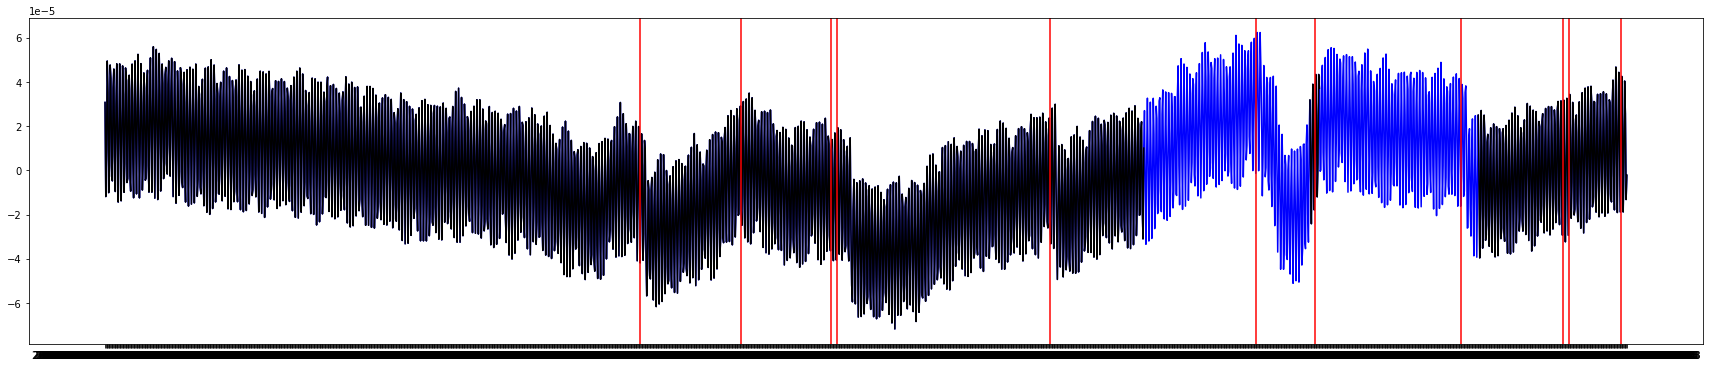

In [10]:
find_peaks(natasha)

[101 403 555 642 762 870]
Detected [101, 147, 214, 403, 555, 642, 762, 870]
[ 45 334 701]
Detected [1045, 1183, 1249, 1334, 1604, 1701]
[181 638]
Detected [2077, 2181, 2276, 2563, 2638, 2874]
[547 677 812]
Detected [3460, 3547, 3636, 3677, 3812, 3887]
[ 92 372 571 667]
Detected [4092, 4372, 4571, 4667]
[668 803]
Detected [5378, 5668, 5803]
[  6  67 347 627 907]
Detected [6006, 6067, 6234, 6347, 6627, 6797, 6907]
[ 18 187 467 747]
Detected [7018, 7187, 7467, 7747]
[ 27 307 587 867]
Detected [8000, 8027, 8307, 8587, 8867]
[ 49 147 427 707 987]
Detected [9049, 9147, 9427, 9707, 9987]
[ 32 267 547 827]
Detected [10032, 10267, 10547, 10827]
[ 34 107 387 667 947]
Detected [11034, 11107, 11312, 11387, 11667, 11947]
[ 11 227 507 786 892]
Detected [12011, 12227, 12507, 12786, 12892]
[ 12  67 347 628 907]
Detected [13012, 13067, 13231, 13347, 13628, 13834, 13907, 13992]
[  8 187 257 465 747]
Detected [14008, 14187, 14257, 14392, 14465, 14648, 14747]
[  0  27 306 587 779 867]
Detected [15000, 150

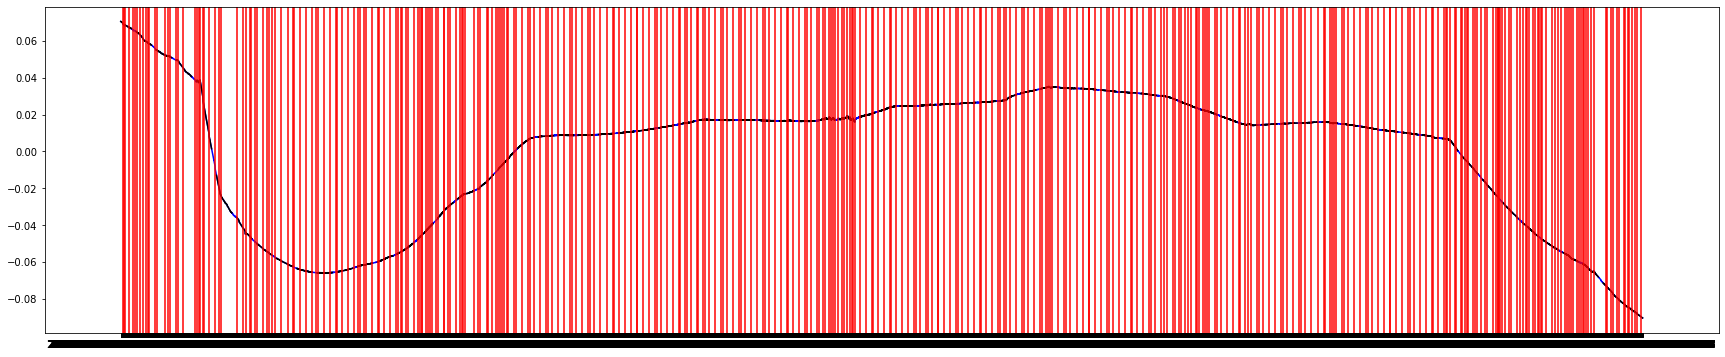

In [7]:
find_peaks(danielp)

[ 23 747]
Detected [23, 747, 960]
[ 27 307 587 867]
Detected [1000, 1027, 1169, 1307, 1587, 1867]
[ 43 147 427 707 986]
Detected [2043, 2147, 2306, 2427, 2584, 2707, 2986]
[ 30 267 547 827]
Detected [3030, 3267, 3547, 3827]
[ 32 107 295 387 556 667 947]
Detected [4032, 4107, 4295, 4387, 4556, 4667, 4850, 4947]
[ 39 227 507 787]
Detected [5039, 5227, 5507, 5787]
[  8  67 347 627 907]
Detected [6008, 6067, 6347, 6627, 6907]
[ 31 187 467 747]
Detected [7031, 7187, 7467, 7747]
[ 26 307 587 867]
Detected [8026, 8307, 8587, 8867]
[ 23 147 427 707 986]
Detected [9023, 9147, 9427, 9707, 9986]
[  9 267 547 827]
Detected [10009, 10267, 10547, 10827]
[  8 107 387 667 947]
Detected [11008, 11107, 11387, 11667, 11947]
[  8 227 507 787]
Detected [12008, 12227, 12507, 12787]
[  8  67 347 627 907]
Detected [13008, 13067, 13347, 13627, 13907, 13993]
[  8 187 467 747]
Detected [14008, 14187, 14467, 14747]
[ 27 307 587 867]
Detected [15000, 15027, 15307, 15587, 15867, 15992]
[ 30 147 426 973]
Detected [1

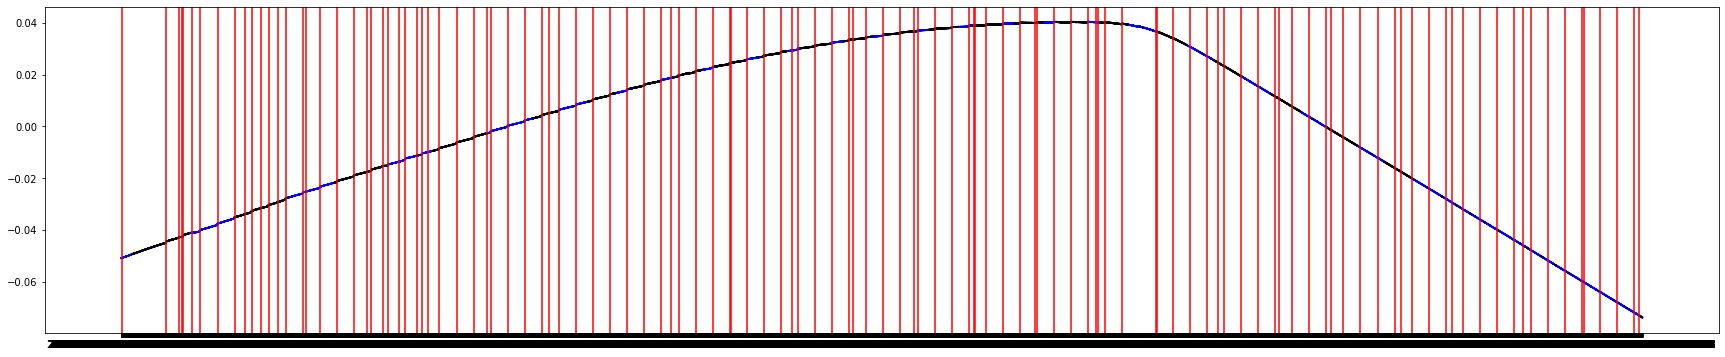

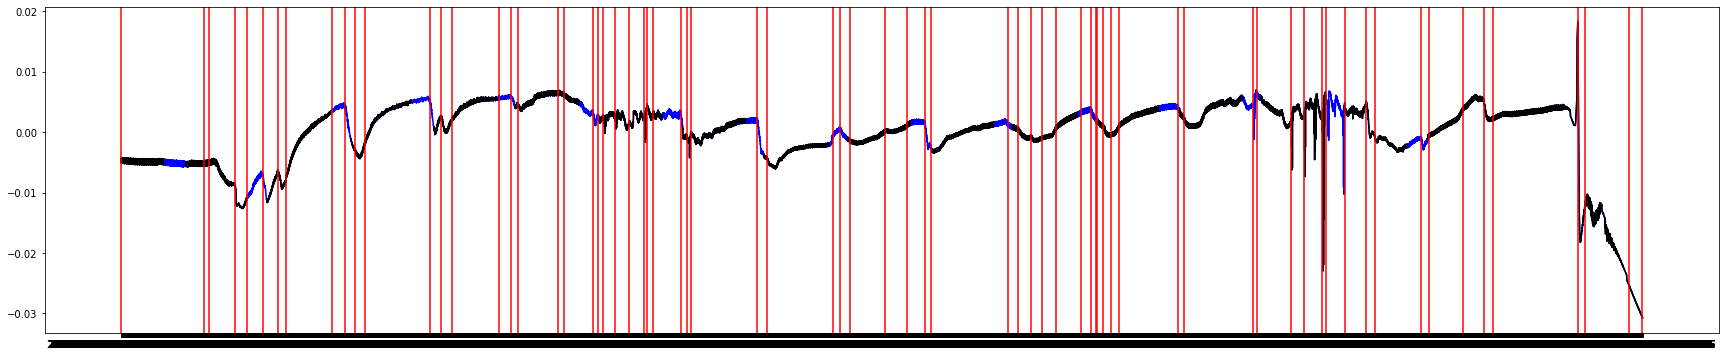

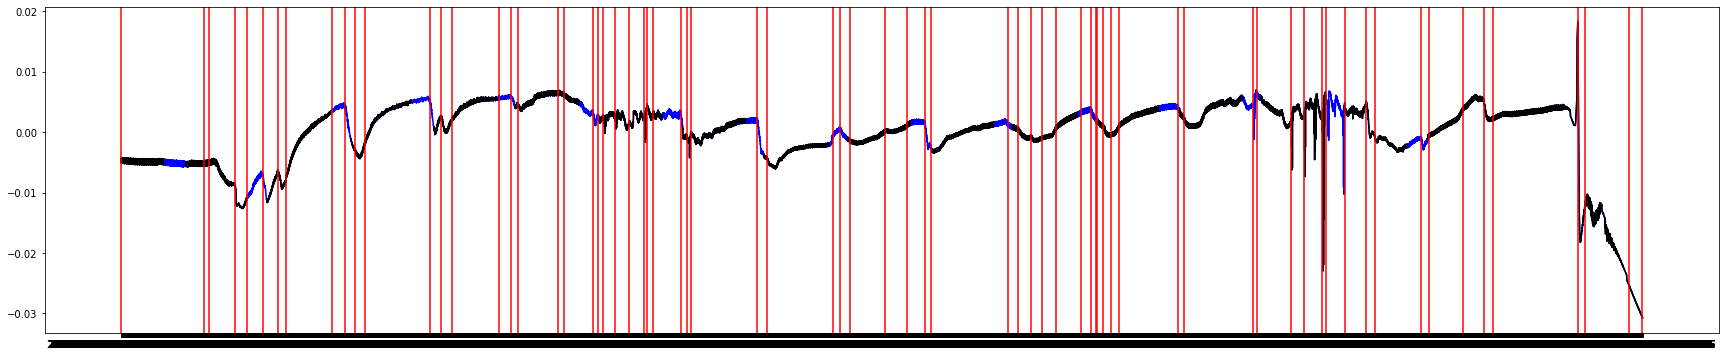

In [8]:
print(find_peaks(nmaniar))
print(find_peaks(skykim))
print(find_peaks(sven))

## Plotting 

[731 992]
Detected [731, 869, 992]
[  0 291 572 852 992]
Detected [1000, 1291, 1572, 1653, 1852, 1992]
[71]
Detected [2000, 2071]


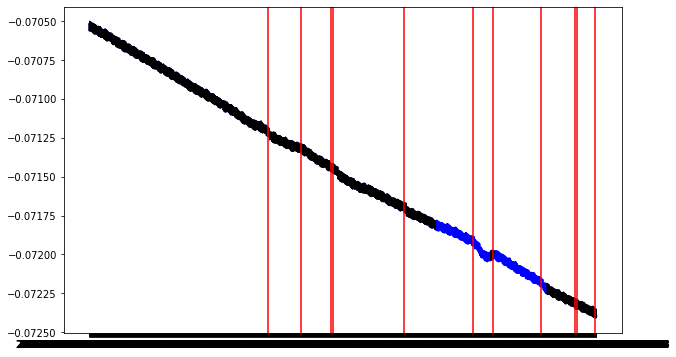

In [176]:
find_peaks(natasha)

In [181]:
indices = np.arange(len(natasha["  CH1"]))

# Fit a first-order polynomial (line) to the data using linear regression
coefficients = np.polyfit(indices,  natasha["  CH1"], 1)
trend = np.polyval(coefficients, indices)

# Remove the trend component from the data
detrended_data = natasha["  CH1"] - trend
find_peaks(detrended_data)

KeyError: "None of [Index(['  CH1', ' CH3'], dtype='object')] are in the [index]"

In [180]:
natasha["  CH1"]

0      -0.070518
1      -0.070562
2      -0.070543
3      -0.070502
4      -0.070517
          ...   
2075   -0.072387
2076   -0.072351
2077   -0.072367
2078   -0.072407
2079   -0.072397
Name:   CH1, Length: 2080, dtype: float64

In [132]:
plot_eog(natasha, ['  CH1', ' CH2', ' CH3'], "Natasha")

pandas.core.frame.DataFrame

In [129]:
plt.figure(figsize=(10,6))

plt.plot(data["UTC_TIME"][0:], b[['  CH1']][0:], label = "ch 1", color="blue")
plt.plot(data["UTC_TIME"][0:], nb[['  CH1']][0:], label = "ch 1", color="black")


NameError: name 'data' is not defined

<Figure size 720x432 with 0 Axes>

In [127]:
prepare_dataset

<function __main__.prepare_dataset(df, coi, sr, name, tw, step, mode_mne=False, thresh=0.00055, ext=False, norm=False, filter_th=None, mode='single')>

In [15]:
# accuracy metrics

#def accuracy_metrics(true_labels,predictions):
  # TODO:

In [91]:
pip install jupyter_contrib_nbextensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 2.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.9/466.9 kB 2.8 MB/s eta 0:00:0000:0100:01
  Created wheel for jupyter_contrib_nbextensions: filename=jupyter_contrib_nbextensions-0.7.0-py2.py3-none-any.whl size=23428786 sha256=041eb713dee6b78af61c741fdc37f7e55dab2471a8f087d1f18fd536b9fccff7
  Stored in directory: /Users/michellekim/Library/Caches/pip/wheels/1a/60/9f/043697d3cd00df43b23bbf4e722366a2abfa68700b6d8411f4
  Created wheel for jupyter_contrib_core: filename=jupyter_contrib_core-0.4.2-py2.py3-none-any.whl size=17474 sha256=a076b8a250f626d341bb4aaf523b6dad1e64090ca2630f35be765ac2d1af7ff0
  Stored in directory: /Users/michellekim/Library/Caches/pip/wheels/c5/75/d2/b881eea79157be355b125d974ec85f88d6e6742acd14387872
Successfully built jupyter_contrib_nbextensions jupyter_contrib_core
Note: you may need to restart

In [96]:
pip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/master

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 2.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


## ML Method


1D CNN for detection
(The benefit of using CNNs for sequence classification is that they can learn from the raw time series data directly, and in turn do not require domain expertise to manually engineer input features. The model can learn an internal representation of the time series data and ideally achieve comparable performance to models fit on a version of the dataset with engineered features.)

Dataloader

In [16]:
from typing import Dict, Any, Tuple, Union, Optional, Callable, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchsummary import summary
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1Score, AUROC
#from mind_ml.models.EEGNet import EEGNetLightning

from torchtyping import TensorType, patch_typeguard
#from typeguard import typechecked

#patch_typeguard()

class CNN(nn.Module):
    """
    CNN model for EOG data.
    """
    def __init__(self,
                 channels: int,
                 dropout: float,
                 kernel_size: int,
                 sample_rate: int = 256,
                 chan_out: int = 256,
                 pool_out: int = 120,
                 n_blocks: int = 3,
                 **kwargs):
        """
        Parameters
        ----------
        channels : int
            Number of EEG channels.
        dropout : float
        """

        super().__init__()

        self.channels = channels
        self.sample_rate = sample_rate
        self.dropout = dropout
        self.kernel_size = kernel_size
        self.chan_out = chan_out
        self.pool_out = pool_out
        self.n_blocks = n_blocks

        """
        TO DO:
        """

        self.blocks = dict()
        for n in range(n_blocks):
            self.blocks[f"block_{n}"] = nn.Sequential(
                nn.Conv1d(in_channels=channels,
                        out_channels=chan_out,
                        kernel_size=kernel_size,
                        padding="same",
                        ),
                nn.LazyBatchNorm1d(),
                nn.GELU(),
                nn.AdaptiveMaxPool1d(output_size = pool_out),
                nn.Dropout(p=dropout),
            )
            channels = chan_out
            chan_out = chan_out//2
            pool_out = pool_out//2

        #This is just to make it run with EEGNetLightning
        self.conv_net = nn.Sequential(*[
            block for block in self.blocks.values()
        ])
        self.classifier_head = nn.Sequential(*[
            nn.Flatten(),
            nn.LazyLinear(out_features = 2),
            nn.GELU()
            ])

    def forward(self, x: TensorType["num_batches", "num_channels", "num_samples"]) -> TensorType["num_batches", "kernal_size", "reduced_channels", 1]:
        # for n in range(self.n_blocks):
        #     x = self.blocks[f"block_{n}"](x)
        x = self.conv_net(x)
        x = self.classifier_head(x)
        return x

from typing import Dict, Any, Tuple, Union, Optional, Callable, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torchsummary import summary
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1Score, AUROC

from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked



# Keras offers a DepthwiseConv2D layer as well as a SeparableConv2D layer.
# The DepthwiseConv2D layer performs a depthwise convolution that acts separately on channels,
# while the SeparableConv2D performs a depthwise convolution that acts separately on channels, followed by a pointwise convolution that mixes channels.
# The pytorch equivalent is as follows:
class DepthwiseConv2d(nn.Module):
    """
    From the documentation of torch.nn.Conv2d:
    If groups == in_channels and out_channels == K * in_channels, where K is a positive integer,
    this operation is also known as a depthwise convolution.
    In pther words, for an input of size (N, C_in, L_in), a depthwise convolution with a depthwise multiplier K,
    can be constructed by providing the arguments (C_in = C_in, C_out = C_in * K, ..., groups = C_in).
    """

    def __init__(self, in_channels, depth_multiplier, **kwargs):
        super(DepthwiseConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels=in_channels,
                                   out_channels=in_channels * depth_multiplier,
                                   groups=in_channels,
                                   **kwargs)

    def forward(self, x):
        out = self.depthwise(x)
        return out


class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, depth_multiplier=1, **kwargs):
        super(SeparableConv2d, self).__init__()
        self.depthwise = DepthwiseConv2d(in_channels, depth_multiplier, **kwargs)
        self.pointwise = nn.Conv2d(in_channels=in_channels * depth_multiplier,
                                   out_channels=out_channels,
                                   kernel_size=(1, 1))

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


class EEGNetBackbone(nn.Module):
    """
    Pytorch implementation of the EEGNet's backbone (convnet) from Lawhern et al. 2018.

    Reference Implementation of EEGNet Version 3 from original authors:
    https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
    """

    def __init__(self,
                 channels= 1,
                 sample_length= 256,
                 kernel_size: int = 64,
                 dropout: float = 0.0,
                 f1: int = 8,
                 d: int = 2,
                 f2: int = 16,
                 sample_rate: int = 256,
                 adjust_for_sample_length: bool = False,
                 **kwargs):
        """
        Parameters
        ----------
        channels : int
            Number of channels in the input data.
        sample_rate : int
            Sample rate of the input data, the architecture is designed for 256 Hz, but should work for higher sample rates.
        dropout : float
            Dropout rate.
        kernel_size : int
            Length of the temporal convolution kernal in the first layer.
        f1, f2 : int
            Number of temporal filters (F1) and number of pointwise filters (F2) to learn.
            Default: F1 = 8, F2 = F1 * D
        d : int
            Number of spatial filters to learn within each temporal convolution.
            Default: d = 2
        """

        super().__init__()

        self.channels = channels
        self.sample_rate = sample_rate
        self.sample_length = sample_length
        self.dropout = dropout
        self.kernel_size = kernel_size
        self.f1 = f1
        self.d = d
        self.f2 = f2

        # The authors describe their updated model as follows:
        # There are two CNN blocks followed by a fully connected layer.
        # Block 1:
        #  - Vanilla 2D Convolution with same padding and kernal size (1, kernel_size)
        #  - Batch normalization
        #  - Depthwise Convolution with kernal size (channels, 1) and depth multiplier d
        #  - Batch normalization
        #  - ELU activation
        #  - Average pooling with kernal size (1, 4)
        #  - Dropout or Spatial Dropout
        # Block 2:
        #  - Depthwise Separable Convolution with output channels f2, kernal size (1, 16) and same padding
        #  - Batch normalization
        #  - ELU activation
        #  - Average pooling with kernal size (1, 8)
        #  - Dropout or Spatial Dropout
        # Flatten

        """
        The following is the orignal implementation using keras


        input1   = Input(shape = (Chans, Samples, 1))
        block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                    input_shape = (Chans, Samples, 1),
                                    use_bias = False)(input1)
        block1       = BatchNormalization()(block1)
        block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                    depth_multiplier = D,
                                    depthwise_constraint = max_norm(1.))(block1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('elu')(block1)
        block1       = AveragePooling2D((1, 4))(block1)
        block1       = dropoutType(dropoutRate)(block1)

        block2       = SeparableConv2D(F2, (1, 16),
                                    use_bias = False, padding = 'same')(block1)
        block2       = BatchNormalization()(block2)
        block2       = Activation('elu')(block2)
        block2       = AveragePooling2D((1, 8))(block2)
        block2       = dropoutType(dropoutRate)(block2)

        flatten      = Flatten(name = 'flatten')(block2)
        """

        # We want the pytorch equivalent of the keras implementation above
        # Note that the input shape for pytorch is (Batch, Channels, Height, Width)
        # for our case height will be the spatial dimension and width will be the temporal dimension
        # spatial dimension is the number of recording channels (not to be confused with "channels" from the pytorch perspective)
        # temporal dimension is the number of samples
        self.pool1 = 4
        # Block 1
        self.block1 = nn.Sequential(
            # shape (batch, 1, channels, samples)
            # first a temporal convolution with kernel size (1, kernel_size) ignoring the spatial dimension
            nn.Conv2d(in_channels=1,
                      out_channels=f1,
                      kernel_size=(1, kernel_size),
                      padding="same",
                      bias=False),
            # shape (batch, f1, channels, samples)
            nn.BatchNorm2d(num_features=f1),
            # shape (batch, f1, channels, samples)
            # next a depthwise convolution over the spatial dimension to learn frequency specific spatial filters
            DepthwiseConv2d(in_channels=f1,
                            depth_multiplier=d,
                            kernel_size=(channels, 1),
                            padding="valid",
                            bias=False),
            # shape (batch, f1 * d, 1, samples)
            nn.BatchNorm2d(num_features=f1 * d),
            # shape (batch, f1 * d, 1, samples)
            nn.ELU(),
            # shape (batch, f1 * d, 1, samples)
            # the pooling is done over the temporal dimension
            nn.AvgPool2d(kernel_size=(1, self.pool1)),
            # shape (batch, f1 * d, 1, samples // 4)
            nn.Dropout(p=dropout),
            # shape (batch, f1 * d, 1, samples // 4)
        )

        # in previous versions the final pooling was hard cored to 8
        # assuming a sample rate of 256 Hz
        self.pool2 = 8

        # but actually if we increase the sample length (more than one second of data)
        # we would want to pool more aggressively to reduce the output size to the same dimension
        # otherwise the fully connected layer will need to be very large
        # we can adjust the pooling size based on ratio of sample length and sample rate
        if adjust_for_sample_length:
            ratio = sample_length / sample_rate
            self.pool2 = int(self.pool2 * ratio)

        # Block 2
        self.block2 = nn.Sequential(
            # shape (batch, f1 * d, 1, samples // 4)
            # again a temporal convolution but this time as a depthwise separable convolution
            SeparableConv2d(in_channels=f1 * d,
                            out_channels=f2,
                            depth_multiplier=1,
                            kernel_size=(1, 16),
                            padding="same",
                            bias=False),
            # shape (batch, f2, samples / 4, 1)
            nn.BatchNorm2d(num_features=f2),
            # shape (batch, f2, samples / 4, 1)
            nn.ELU(),
            # shape (batch, f2, samples / 4, 1)
            # the pooling is done over the temporal dimension
            nn.AvgPool2d(kernel_size=(1, self.pool2)),
            # shape (batch, f2, samples / 32, 1)
            nn.Dropout(p=dropout),
            # shape (batch, f2, samples / 32, 1)
        )

        self.output_shape = (f2, sample_length // (self.pool1*self.pool2), 1)

    def forward(self, x: TensorType["num_batches", 1, "num_channels", "num_samples"]) -> TensorType["num_batches", "kernal_size", "reduced_channels", 1]:
        x = self.block1(x)
        x = self.block2(x)
        return x



class EEGNet(nn.Module):
    """
    Pytorch implementation of the EEGNet model from Lawhern et al. 2018.

    Reference Implementation of EEGNet Version 3 from original authors:
    https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
    """

    def __init__(self,
                 num_classes= 2,
                 classifier_hidden_units: Optional[int] = None,
                 classifier_num_layers: int = 1,
                 **backbone_kwargs):
        """
        Parameters
        ----------
        num_classes : int
            Number of classes to predict
        """

        super().__init__()

        self.classifier_hidden_units = classifier_hidden_units
        self.classifier_num_layers = classifier_num_layers
        self.classifier_num_hidden_layers = classifier_num_layers - 1
        self.num_classes = num_classes
        assert self.classifier_num_hidden_layers == 0 or self.classifier_hidden_units is not None, "If classifier_num_layers > 1, classifier_hidden_units must be specified"
        """
        conv_net = ...
        flatten      = Flatten(name = 'flatten')(conv_net)

        dense        = Dense(nb_classes, name = 'dense',
                            kernel_constraint = max_norm(norm_rate))(flatten)
        softmax      = Activation('softmax', name = 'softmax')(dense)
        return Model(inputs=input1, outputs=softmax)
        """
        # for backwards compatibility with previous versions of this EEGNet implementation we need to use nn.Sequential
        # otherwise we couldn't use the pretrained weights / re-evaulate older models
        # self.conv_net = EEGNetBackbone(**backbone_kwargs)
        backbone = EEGNetBackbone(**backbone_kwargs)
        self.dropout = backbone.dropout

        self.conv_net = nn.Sequential(*[
            backbone.block1,
            backbone.block2,
        ])
        # output shape of conv_net is (batch, f2, samples / 32, 1)
        classifier_input_units = np.array(backbone.output_shape).prod()
        input_units = [classifier_input_units] + [classifier_hidden_units] * self.classifier_num_hidden_layers
        output_units = [classifier_hidden_units] * self.classifier_num_hidden_layers + [num_classes]

        classifier_layers = [nn.Flatten()]
        for in_features, out_features in zip(input_units, output_units):
            classifier_layers.append(nn.Linear(in_features=in_features, out_features=out_features))
            classifier_layers.append(nn.ELU())

        # remove the last activation layer
        classifier_layers = classifier_layers[:-1]

        self.classifier_head = nn.Sequential(*classifier_layers)
        # output shape of classifier_head is (batch, num_classes)

    def forward(self, x: TensorType["num_batches", 1, "num_channels", "num_samples"]) -> TensorType["num_batches", "num_classes"]:
        x = self.conv_net(x)
        x = self.classifier_head(x)
        return x

    def embed(self, x: TensorType["num_batches", 1, "num_channels", "num_samples"]) -> TensorType["num_batches", "classifier_input_units"]:
        x = self.conv_net(x)
        x = x.view(x.shape[0], -1)
        return x


class ConditionalEEGNet(nn.Module):
    """
    A model based on EEGNet but with the ability to condition it's prediction for any given sample on samples from a calibration sequence

    The architecture changes as follows:
    - the input is now a tuple (x_calib, x_sample) where the shapes are
        - x_calib: (num_batches, num_calib_samples, 1, num_channels, num_samples)
        - x_sample: (num_batches, 1, num_channels, num_samples)
        Note: for technical reasons the input to the forward method is a single tensor with shape (num_batches, num_sequences, 1, num_channels, num_samples)
        where num_sequences = num_calib_samples + 1
    - both x_calib and x_sample are passed through the EEGNet backbone
    - the outputs for x_calib are aggregated (various aggregation methods are possible)
    - the output for x_sample is then aggregated with the x_calib_aggregated (again various aggregation methods are possible)
    - the aggregated output is passed through a classifier head
    """

    def __init__(self,
                 num_classes: int,
                 calibration_aggregation_method: str,
                 pre_classifier_aggregation_method: str,
                 classifier_hidden_units: Optional[int] = None,
                 classifier_num_layers: int = 1,
                 **backbone_kwargs):
        """
        Parameters
        ----------
        num_classes : int
            Number of classes to predict
        calibration_aggregation_method : str
            The method used to aggregate the outputs of the EEGNet backbone for the calibration sequence
        pre_classifier_aggregation_method : str
            The method used to aggregate the outputs of the EEGNet backbone for the sample and the aggregated calibration sequence
        """

        super().__init__()

        self.num_classes = num_classes
        self.calibration_aggregation_method = calibration_aggregation_method
        self.pre_classifier_aggregation_method = pre_classifier_aggregation_method

        self.classifier_hidden_units = classifier_hidden_units
        self.classifier_num_layers = classifier_num_layers
        self.classifier_num_hidden_layers = classifier_num_layers - 1
        self.num_classes = num_classes
        assert self.classifier_num_hidden_layers == 0 or self.classifier_hidden_units is not None, "If classifier_num_layers > 1, classifier_hidden_units must be specified"

        self.conv_net = EEGNetBackbone(**backbone_kwargs)
        # output shape is (batch, f2, samples / 32, 1)
        conv_net_output_shape = self.conv_net.output_shape

        # two times the backbone output shape
        # because we concatenate the aggregated calibration sequence with the sample's output
        # classifier input shape might differ depending on pre_classifier_aggregation_method
        if pre_classifier_aggregation_method == "concat":
            classifier_input_shape = (2, *conv_net_output_shape)
        elif pre_classifier_aggregation_method in ["mean", "max", "min"]:
            classifier_input_shape = (1, *conv_net_output_shape)
        elif "difference" in pre_classifier_aggregation_method:
            classifier_input_shape = (1, *conv_net_output_shape)
        else:
            raise ValueError(f"Unknown pre_classifier_aggregation_method: {pre_classifier_aggregation_method}")

        classifier_input_units = np.array(classifier_input_shape).prod()
        input_units = [classifier_input_units] + [classifier_hidden_units] * self.classifier_num_hidden_layers
        output_units = [classifier_hidden_units] * self.classifier_num_hidden_layers + [num_classes]

        classifier_layers = [nn.Flatten(start_dim=-4)]
        for in_features, out_features in zip(input_units, output_units):
            classifier_layers.append(nn.Linear(in_features=in_features, out_features=out_features))
            classifier_layers.append(nn.ELU())

        # remove the last activation layer
        classifier_layers = classifier_layers[:-1]

        self.classifier_head = nn.Sequential(*classifier_layers)
        # output shape of classifier_head is (batch, num_classes)

    def forward(self, x: TensorType["num_batches", "num_sequences", 1, "num_channels", "num_samples"]) -> TensorType["num_batches", "num_classes"]:
        # first pass all samples through the conv_net backbone
        # the conv_net backbone operates on 4D (batched) tensors so we need to flatten the first two dimensions and then reshape the output back to the original shape
        num_batches, num_sequences = x.shape[:2]
        x = x.view(num_batches * num_sequences, *x.shape[2:])
        x = self.conv_net(x)
        x = x.view(num_batches, num_sequences, *x.shape[1:])

        # split the input tensor into calibration and sample tensors
        x_calib, x_sample = x[:, :-1], x[:, -1:]

        # aggregate the outputs of the conv_net backbone for the calibration sequence
        if self.calibration_aggregation_method == "mean":
            x_calib = x_calib.mean(dim=1).unsqueeze(1)
        elif self.calibration_aggregation_method == "max":
            x_calib = x_calib.max(dim=1)[0].unsqueeze(1)
        elif self.calibration_aggregation_method == "min":
            x_calib = x_calib.min(dim=1)[0].unsqueeze(1)
        elif self.calibration_aggregation_method == "none":
            # x_calib stays the same
            # but for this case we need to expand the dimension of x_sample instead so that the concatenation below works
            x_sample = x_sample.expand(x_calib.shape).unsqueeze(1)
            x_calib = x_calib.unsqueeze(1)
        else:
            raise ValueError(f"Unknown calibration_aggregation_method: {self.calibration_aggregation_method}")

        # aggregate the outputs of the conv_net backbone for the sample and the aggregated calibration sequence
        x_pre_classifier = torch.cat([x_calib, x_sample], dim=1)
        assert x_pre_classifier.shape[
            1] == 2, f"Expected x_pre_classifier to have shape (batch, 2, ...), but got {x_pre_classifier.shape}"

        # since we operate over axis=1 where we will always have 2 elements, we can also use other aggregation methods here
        if self.pre_classifier_aggregation_method == "mean":
            x_pre_classifier = x_pre_classifier.mean(dim=1).unsqueeze(1)
        elif self.pre_classifier_aggregation_method == "max":
            x_pre_classifier = x_pre_classifier.max(dim=1)[0].unsqueeze(1)
        elif self.pre_classifier_aggregation_method == "min":
            x_pre_classifier = x_pre_classifier.min(dim=1)[0].unsqueeze(1)
        elif self.pre_classifier_aggregation_method == "difference":
            x_pre_classifier = (x_pre_classifier[:, 0] - x_pre_classifier[:, 1]).unsqueeze(1)
        elif self.pre_classifier_aggregation_method == "abs_difference":
            x_pre_classifier = torch.abs(x_pre_classifier[:, 0] - x_pre_classifier[:, 1]).unsqueeze(1)
        elif self.pre_classifier_aggregation_method == "square_difference":
            x_pre_classifier = torch.square(x_pre_classifier[:, 0] - x_pre_classifier[:, 1]).unsqueeze(1)
        elif self.pre_classifier_aggregation_method == "concat":
            x_pre_classifier = x_pre_classifier
        # even various distance metrics are possible here
        elif self.pre_classifier_aggregation_method == "cosine_similarity":
            x_pre_classifier = F.cosine_similarity(x_pre_classifier[:, 0], x_pre_classifier[:, 1])
        elif self.pre_classifier_aggregation_method == "euclidean_distance":
            x_pre_classifier = F.pairwise_distance(x_pre_classifier[:, 0], x_pre_classifier[:, 1])
        else:
            raise ValueError(f"Unknown pre_classifier_aggregation_method: {self.pre_classifier_aggregation_method}")

        # TODO: This might be 6 dimensional in the case of "none" for the calibration_aggregation_method
        assert len(x_pre_classifier.shape) >= 5, \
            f"Expected x_pre_classifier to be at least 5-dimensional, but got {x_pre_classifier.shape}"

        if len(x_pre_classifier.shape) == 6:
            # switch axis 1 and 2, since the last 4 dimensions are operated on by the classifier head
            x_pre_classifier = x_pre_classifier.permute(0, 2, 1, 3, 4, 5)
        # pass the aggregated output through the classifier head
        x = self.classifier_head(x_pre_classifier)

        if len(x.shape) == 3:
            # average over the second dimension
            x = x.mean(dim=1)

        return x


# pytorch lightning module of EEGNet
class EEGNetLightning(pl.LightningModule):

    metric_name_replacements = {
        "MulticlassAccuracy": "acc",
        "MulticlassPrecision": "prec",
        "MulticlassRecall": "rec",
        "MulticlassF1Score": "f1",
        "MulticlassROC": "roc",
        "MulticlassAUC": "auc",
        "MulticlassAUROC": "auroc",
        "BinaryAccuracy": "acc",
        "BinaryPrecision": "prec",
        "BinaryRecall": "rec",
        "BinaryF1Score": "f1",
        "BinaryROC": "roc",
        "BinaryAUC": "auc",
        "BinaryAUROC": "auroc",
    }

    @staticmethod
    def shorten_metric_name(name: str) -> str:
        for k, v in EEGNetLightning.metric_name_replacements.items():
            name = name.replace(k, v)
        return name

    @staticmethod
    def shorten_metric_names(metrics: Dict[str, Any]) -> Dict[str, float]:
        return {
            EEGNetLightning.shorten_metric_name(k): (v.item() if isinstance(v, torch.Tensor) else v)
            for k, v in metrics.items()
        }

    def __init__(self, **hparams):
        super().__init__()
        self.use_class_weights = hparams.get("use_class_weights", False)
        class_weights = hparams.pop("class_weights", None)
        self.class_weights = class_weights if self.use_class_weights else None

        self.save_hyperparameters(hparams, ignore=["class_weights"])
        self.eegnet = EEGNet(**hparams)

        # check that learning_rate and optimizer_class exists
        assert hasattr(self.hparams, "learning_rate"), "learning_rate must be specified in hparams"
        assert hasattr(self.hparams, "optimizer_class"), "optimizer_class must be specified in hparams"

        #### metrics ####
        if self.hparams.num_classes == 2:
            metric_params = dict(task="binary")
        else:
            metric_params = dict(num_classes=self.hparams.num_classes, task="multiclass", average='macro')
        metrics = MetricCollection([
            Accuracy(**metric_params),
            Precision(**metric_params),
            Recall(**metric_params),
            F1Score(**metric_params),
            AUROC(**metric_params),
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

    def forward(self, x: TensorType["num_batches", 1, "num_samples", "num_channels"]) -> TensorType["num_batches", "num_classes"]:
        x = x.squeeze(1)
        # x is of shape (batch, samples, channels) but we need (batch, 1, channels, samples)
        x = torch.swapaxes(x, -2, -1)
        x = x.unsqueeze(-3)
        y_hat = self.eegnet(x)
        return y_hat

    def embed(self, x: TensorType["num_batches", 1, "num_samples", "num_channels"]) -> TensorType["num_batches", "num_embedding_dims"]:
        x = x.squeeze(1)
        # x is of shape (batch, samples, channels) but we need (batch, 1, channels, samples)
        x = torch.swapaxes(x, -2, -1)
        x = x.unsqueeze(-3)
        x = self.eegnet.embed(x)
        return x

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        print(batch)
        x, y = batch[:2]
        print(x)
        print("SHAPE", x.shape)
        batch_size = x.shape[0]
        y_hat = self(x)
        if self.class_weights is not None and not isinstance(self.class_weights, torch.Tensor):
            self.class_weights = torch.tensor(self.class_weights, device=y_hat.device, dtype=torch.float)
        loss = F.cross_entropy(y_hat, y, weight=self.class_weights)
        self.log("train_loss", loss, batch_size=batch_size)
        # calculate metrics
        preds = y_hat.argmax(-1) if self.hparams.num_classes == 2 else y_hat
        y_metrics = y.clone()
        y_metrics[y!=0] = 1
        output = self.train_metrics(preds, y_metrics)
        # shorten the names of the metrics
        output = {
            EEGNetLightning.shorten_metric_name(k): v
            for k, v in output.items()
        }
        # calculate balance of classes
        # convert classes to onehot
        y_onehot = F.one_hot(y, num_classes=self.hparams.num_classes)
        # calculate class balance
        class_balance = y_onehot.sum(dim=0) / len(y_onehot)
        # log class balance
        for i, b in enumerate(class_balance):
            self.log(f"train_class_balance_{i}", b, on_step=False, on_epoch=True, prog_bar=False)

        self.log_dict(output, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch[:2]
        batch_size = x.shape[0]
        y_hat = self(x)
        if self.class_weights is not None and not isinstance(self.class_weights, torch.Tensor):
            self.class_weights = torch.tensor(self.class_weights, device=y_hat.device, dtype=torch.float)
        loss = F.cross_entropy(y_hat, y, weight=self.class_weights)
        self.log("val_loss", loss, batch_size=batch_size)
        # calculate metrics
        preds = y_hat.argmax(-1) if self.hparams.num_classes == 2 else y_hat
        y_metrics = y.clone()
        y_metrics[y!=0] = 1
        output = self.val_metrics(preds, y_metrics)
        # shorten the names of the metrics
        output = {
            EEGNetLightning.shorten_metric_name(k): v
            for k, v in output.items()
        }

        self.log_dict(output, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def test_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch[:2]
        batch_size = x.shape[0]
        y_hat = self(x)
        if self.class_weights is not None and not isinstance(self.class_weights, torch.Tensor):
            self.class_weights = torch.tensor(self.class_weights, device=y_hat.device, dtype=torch.float)
        loss = F.cross_entropy(y_hat, y, weight=self.class_weights)
        self.log("test_loss", loss, batch_size=batch_size)
        # calculate metrics
        preds = y_hat.argmax(-1) if self.hparams.num_classes == 2 else y_hat
        y_metrics = y.clone()
        y_metrics[y!=0] = 1
        output = self.test_metrics(preds, y_metrics)
        # shorten the names of the metrics
        output = {
            EEGNetLightning.shorten_metric_name(k): v
            for k, v in output.items()
        }

        self.log_dict(output, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def predict_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch[:2]
        y_hat = self(x)
        return y_hat

    def configure_optimizers(self):
        assert hasattr(torch.optim, self.hparams.optimizer_class),\
            f"{self.hparams.optimizer_class} is not a valid optimizer from torch.optim"
        optimizer_class = getattr(torch.optim, self.hparams.optimizer_class)
        optimizer = optimizer_class(
            [
                {  # conv layer parameters
                    "params": filter(lambda p: p.requires_grad, self.eegnet.conv_net.parameters()),
                    "weight_decay": getattr(self.hparams, "conv_weight_decay", 0.0),
                },
                {  # fc layer parameters
                    "params": filter(lambda p: p.requires_grad, self.eegnet.classifier_head.parameters()),
                    "weight_decay": getattr(self.hparams, "fc_weight_decay", 0.0),
                },
            ],
            lr=self.hparams.learning_rate)
        return optimizer


class ConditionalEEGNetLightning(EEGNetLightning):
    def __init__(self, **hparams):
        super().__init__(**hparams)
        self.eegnet = ConditionalEEGNet(**hparams)

    def forward(self, x: TensorType["num_batches", "sequence_length", "num_samples", "num_channels"]) -> TensorType["num_batches", "num_classes"]:
        # x is of shape (..., samples, channels) but we need (..., 1, channels, samples)
        x = torch.swapaxes(x, -2, -1)
        x = x.unsqueeze(-3)
        y_hat = self.eegnet(x)
        return y_hat


class CNNLightning(EEGNetLightning):
    def __init__(self, **hparams):
        super().__init__(**hparams)
        self.eegnet = CNN(**hparams)

    def forward(self, x: TensorType["num_batches", 1, "num_channels", "num_samples"]) -> TensorType["num_batches", "num_classes"]:
        # x is of shape (..., samples, channels) but we need (..., 1, channels, samples)
        #x = torch.swapaxes(x, -2, -1)
        #x = x.unsqueeze(-3)
        x = x.squeeze(axis=1)
        x = torch.swapaxes(x, -2, -1)
        y_hat = self.eegnet(x)
        return y_hat

    def configure_optimizers(self):
        assert hasattr(torch.optim, self.hparams.optimizer_class),\
            f"{self.hparams.optimizer_class} is not a valid optimizer from torch.optim"
        optimizer_class = getattr(torch.optim, self.hparams.optimizer_class)
        optimizer = optimizer_class(
            [
                {  # conv layer parameters
                    "params": filter(lambda p: p.requires_grad, self.eegnet.conv_net.parameters()),
                    "weight_decay": getattr(self.hparams, "conv_weight_decay", 0.0),
                },
                {  # fc layer parameters
                    "params": filter(lambda p: p.requires_grad, self.eegnet.classifier_head.parameters()),
                    "weight_decay": getattr(self.hparams, "fc_weight_decay", 0.0),
                },
            ],
            lr=self.hparams.learning_rate)

        # lr = torch.optim.lr_scheduler.CyclicLR(
        #     optimizer, base_lr = self.hparams.learning_rate,
        #     max_lr = 4*self.hparams.learning_rate,
        #     step_size_up = 4*int(self.stepsize),
        #     mode = "triangular",
        #     cycle_momentum = False
        #     )

        lr = torch.optim.lr_scheduler.OneCycleLR(
            optimizer = optimizer,
            max_lr = self.hparams.learning_rate,
            epochs = self.trainer.max_epochs,
            steps_per_epoch = self.trainer.estimated_stepping_batches // self.trainer.max_epochs,
            cycle_momentum = True
            )

        scheduler = {
            "scheduler": lr,
            "interval": "step",
            "name": "Learning Rate Scheduling"
        }
        return [optimizer], [scheduler]
# pytorch lightning module of EEGNet


ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
# Custom Dataset Class
## Needs ATLEAST 3 class methods
## __init__, __len__, __getitem__

def change(x):
    if x =="B":
      return 1
    elif x=="N":
      return 0

from torch.utils.data import Dataset
class EOGDataLoader(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self):
        # load data
        path1 = '/content/drive/MyDrive/Colab Notebooks/Streamer-main/ml/test1/exg0.csv'

        data = pd.read_csv(path1)
        # extract labels
        big_buffer = np.array(data)
        mean = data[['  CH1', ' CH3']].mean(axis=1).to_numpy()
        #filtered = mne.filter.filter_data(mean*1e-6, 250, 1 , 18, pad='symmetric')
        filtered = signal_filter_butterworth(mean,sr=250)
        self.df = filtered
        print(data)
        self.df_labels=data[[' LABEL']]
        # drop non numeric columns to make tutorial simpler, in real life do categorical encoding
        # conver to torch dtypes

        self.dataset=torch.tensor(self.df.copy()).float()
        self.df_labels =  data[[' LABEL']].applymap(lambda x: change(x))
        self.labels=torch.tensor(self.df_labels.to_numpy().reshape(-1)).long()

    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.dataset)

    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

In [ ]:
eogmodel = CNNLightning(learning_rate = 0.1, optimizer_class="SGD", num_classes=2, channels=2, dropout=0.01,kernel_size=3)
# train model
trainer = pl.Trainer()
train_loader = EOGDataLoader()
trainer.fit(model=eogmodel, train_dataloaders=train_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader

                         UTC_TIME    SAMPLE_NUMBER       CH1       CH2  \
0      2023-05-13 16:00:07.726171            153.0  0.082748  0.082429   
1      2023-05-13 16:00:07.730171            154.0  0.083284  0.083086   
2      2023-05-13 16:00:07.734171            155.0  0.083232  0.082986   
3      2023-05-13 16:00:07.738171            156.0  0.082553  0.082239   
4      2023-05-13 16:00:07.742171            157.0  0.082637  0.082315   
...                           ...              ...       ...       ...   
17155  2023-05-13 16:01:21.032386             56.0  0.046147  0.047253   
17156  2023-05-13 16:01:21.036386             57.0  0.046157  0.047279   
17157  2023-05-13 16:01:21.040386             58.0  0.046086  0.047201   
17158  2023-05-13 16:01:21.044386             59.0  0.046010  0.047135   
17159  2023-05-13 16:01:21.048386             60.0  0.046000  0.047132   

            CH3  LABEL      
0      0.066152      N NaN  
1      0.065995      N NaN  
2      0.065898      N N

INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | eegnet        | CNN              | 124 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.499     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

(tensor(1.9325e-05), tensor(0))
tensor(1.9325e-05)
SHAPE torch.Size([])


IndexError: ignored

# IGNORE BELOW: experimenting

In [22]:
blink10

,UTC_TIME SAMPLE_NUMBER CH1 CH2 CH3
0,2023-03-27 13:38:51.753709 207.0 0.01009494159...
1,2023-03-27 13:38:51.757709 208.0 0.01011312101...
2,2023-03-27 13:38:51.761709 209.0 0.01011461112...
3,2023-03-27 13:38:51.765709 210.0 0.01008123252...
4,2023-03-27 13:38:51.769709 211.0 0.01006603334...
...,...
14555,2023-03-27 13:39:50.074588 210.0 0.00905186031...
14556,2023-03-27 13:39:50.078588 211.0 0.00905960891...
14557,2023-03-27 13:39:50.082588 212.0 0.00901550147...
14558,2023-03-27 13:39:50.086588 213.0 0.00898301694...


In [97]:
find_all_peaks(blink10[200:],i)

[   0   95  872 1469 2078 2692 3170 8632]
Detected [array([1, 2]), array([96, 97]), array([873, 874]), array([1470, 1471]), array([2079, 2080]), array([2693, 2694]), array([3171, 3172]), array([4332, 4333]), array([5048, 5049]), array([8633, 8634])]


[array([1, 2]),
 array([96, 97]),
 array([873, 874]),
 array([1470, 1471]),
 array([2079, 2080]),
 array([2693, 2694]),
 array([3171, 3172]),
 array([4332, 4333]),
 array([5048, 5049]),
 array([8633, 8634])]

In [99]:
find_all_peaks(natasha,i)

#white square

[ 731  869 1011 1291 1572 1852 2071]
Detected [array([592, 593]), array([732, 733]), array([870, 871]), array([1012, 1013]), array([1292, 1293]), array([1573, 1574]), array([1654, 1655]), array([1853, 1854]), array([1932, 1933]), array([2072, 2073])]


[array([592, 593]),
 array([732, 733]),
 array([870, 871]),
 array([1012, 1013]),
 array([1292, 1293]),
 array([1573, 1574]),
 array([1654, 1655]),
 array([1853, 1854]),
 array([1932, 1933]),
 array([2072, 2073])]

In [102]:
natasha.columns

Index(['UTC_TIME', '  SAMPLE_NUMBER', '  CH1', ' CH2', ' CH3', ' LABEL', ' '], dtype='object')

In [108]:
# for all data in 30s -> true blinks is 1 min
# find max of avg data-> do this in real time
newdata = natasha

mne.set_log_level(verbose='ERROR')
#big_buffer = np.array(data) #newdata

mean = newdata[['  CH1', ' CH2',' CH3']].mean(axis=1).to_numpy()
filtered = mne.filter.filter_data(mean*1e-6, 250, 1 , 18, pad='symmetric')
"""
filter_smooth = uniform_filter1d(filter_butter, size=wind_smooth)
left_base_mean = np.mean(filter_butter[0, -left_base_start:-left_base_end])
left_base_std = np.std(filter_butter[0,-left_base_start:-left_base_end])
rms = np.sqrt(np.mean((filter_butter[0, -left_base_start:-left_base_end])**2))
max_peak_wind = np.max(filter_butter[0,-peak_wind_start:-peak_wind_end])
threshold = left_base_mean + left_base_std * tolerance
#threshold = self.rms * self.tolerance


                    # Wait n cycles before detect next blink in case a blink already happend
                    # (small buffer number of samples per cycle)

                    #shared_list[0] = ((float)(features[0][2])/10000 + (float)(features[0][3])/10000  + (float)(features[0][4])/10000)/3

                    #smd_config["EOG"] = (float)(features[0][2])/10000

if self.space_cycles == self.max_space_cycles:
  if self.max_peak_wind > (7*self.old_threshold):
    # disturbance
  else:
    if self.max_peak_wind > self.threshold :
                        #self.space_cycles = self.space_cycles - self.max_space_cycles
          self.blink_count+=1


      self.old_threshold = self.threshold

                else:
                    self.buffer = np.vstack((self.buffer, features))

            else:

                self.big_buffer = np.vstack((self.big_buffer, features))
        # imu

mne.preprocessing.peak_finder(newdata['CH1'], )

#peaks, _ = mne.preprocessing.peak_finder(newdata[0], thresh)) #
#len(peaks) = true_blinks
"""


'\nfilter_smooth = uniform_filter1d(filter_butter, size=wind_smooth)\nleft_base_mean = np.mean(filter_butter[0, -left_base_start:-left_base_end])\nleft_base_std = np.std(filter_butter[0,-left_base_start:-left_base_end])\nrms = np.sqrt(np.mean((filter_butter[0, -left_base_start:-left_base_end])**2))\nmax_peak_wind = np.max(filter_butter[0,-peak_wind_start:-peak_wind_end])\nthreshold = left_base_mean + left_base_std * tolerance\n#threshold = self.rms * self.tolerance\n\n\n                    # Wait n cycles before detect next blink in case a blink already happend\n                    # (small buffer number of samples per cycle)\n\n                    #shared_list[0] = ((float)(features[0][2])/10000 + (float)(features[0][3])/10000  + (float)(features[0][4])/10000)/3\n\n                    #smd_config["EOG"] = (float)(features[0][2])/10000\n\nif self.space_cycles == self.max_space_cycles:\n  if self.max_peak_wind > (7*self.old_threshold):\n    # disturbance\n  else:\n    if self.max_peak_w

In [168]:
newdata = natasha

mne.set_log_level(verbose='ERROR')
#big_buffer = np.array(data) #newdata

mean = newdata[['  CH1']].mean(axis=1).to_numpy()
filtered = mne.filter.filter_data(mean*1e-6, 250, 1 , 18, pad='symmetric')

In [175]:
mne.filter

In [169]:
peaks, _ = mne.preprocessing.peak_finder(filtered, 0.8*max(filtered)) #

In [170]:
peaks

array([   2, 1688])

In [111]:
newdata.columns

Index(['UTC_TIME', '  SAMPLE_NUMBER', '  CH1', ' CH2', ' CH3', ' LABEL', ' '], dtype='object')

In [ ]:
# generate characteristics of user's blink type:
# blink strength, blink duration,
print(newdata['UTC_TIME'][0])
print(newdata['UTC_TIME'][len(newdata['UTC_TIME'])-1])

2023-01-10 10:28:34.405243
2023-01-10 10:28:53.050895


In [112]:
# generate characteristics of user's blink type:
# blink strength, blink duration,
print(newdata['UTC_TIME'][0])
print(newdata['UTC_TIME'][len(newdata['UTC_TIME'])-1])

2023-05-15 14:44:42.920685
2023-05-15 14:44:51.623178


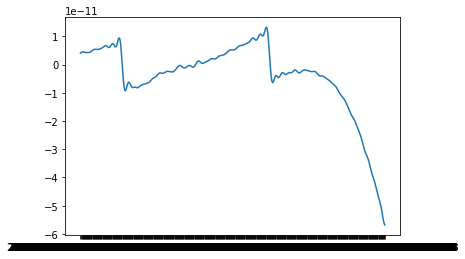

In [113]:
plt.plot(newdata["UTC_TIME"][1500:3000], filtered[1500:3000], label = "ch 1")

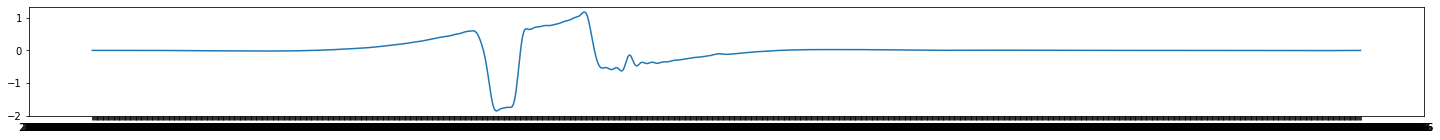

In [ ]:
plt.plot(newdata["UTC_TIME"][1500:3000], filtered[1500:3000], label = "ch 1")

In [ ]:
max(filtered)

1.1771680956055763

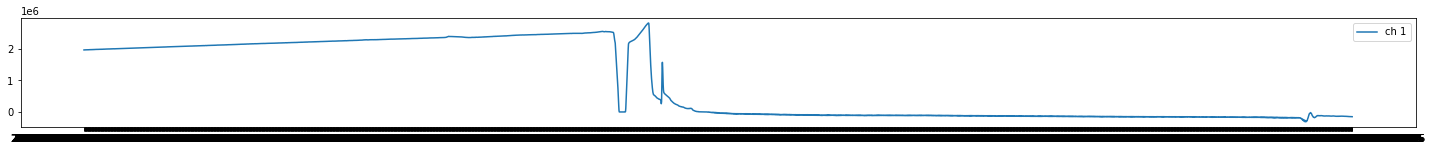

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# test 60 seconds -> clean and find peaks
# change threshold
# create data
#x = [1,2,3,4,5]
#y = [3,3,3,3,3]

# plot lines
plt.plot(newdata["UTC_TIME"], newdata["CH2"], label = "ch 1")

# get num of blinks in 60s
#plt.plot(y, x, label = "ch 2")
#plt.plot(x, np.sin(x), label = "ch 3")
plt.legend()
plt.show()

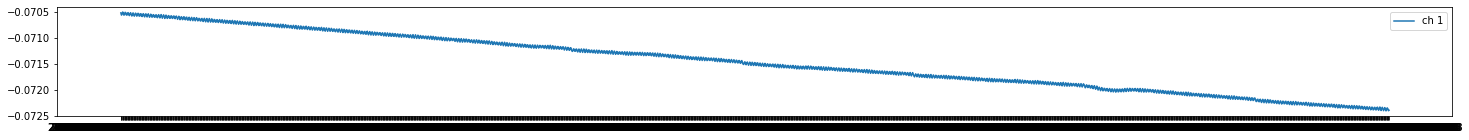

In [173]:
#natasha
import matplotlib.pyplot as plt
import numpy as np
# test 60 seconds -> clean and find peaks
# change threshold
# create data
#x = [1,2,3,4,5]
#y = [3,3,3,3,3]

# plot lines
plt.plot(natasha["UTC_TIME"], natasha["  CH1"], label = "ch 1")

# get num of blinks in 60s
#plt.plot(y, x, label = "ch 2")
#plt.plot(x, np.sin(x), label = "ch 3")
plt.legend()
plt.show()

In [ ]:
peaks1 , _ = mne.preprocessing.peak_finder(newdata['CH2'], extrema=1, thresh=100, verbose=False)

In [ ]:
peaks1

In [ ]:
"ld. The thredhold of eye blink is 80% of the average maximum. Also
while running program the baseline will be newly calculated every
3 epochs (6 seconds) to adjust a new threshold within limited boundaries.
After that the system also calculated the energy of eye behavior in each
subject to detect eye blinks and eye movements. If the signal is in the
range of eye behavior, eye blinks and eye movements will perform. If the
signal exceeds a range of eye behavior, artifacts will perform. Thereby,
our systems can detect eye behavior out of artifacts and use eye behavior
to detect state of drowsiness."

# every 7 seconds check if blink-> recalculate threshold, sample number

In [ ]:
# eeg: if showing moving around then noise


In [ ]:
# calculate number: num of peaks

-- patient calculate type of blink


number of peaks

after 1 minute: send to another script to calculate the num of peaks

# blink 6 times in 30s

# load data stream for 30s

after 30 s: calculate num of peaks



# clean and detect peaks
# ML pipeline: train model on inividual user (


# threshold to get X num of peaks in 1 min